# Dataset download and Exploration

In this section we will download a filtered version of the [MCMD Dataset](https://zenodo.org/records/5025758). The original raw version is extremely large and contains many files that are not relevant for this demonstration. The collection and filtration process is adopted from the [NMT-based Commit Generation](https://dl.acm.org/doi/pdf/10.1145/3238147.3238190?casa_token=PQjtlNRBvJgAAAAA:dGLvlol87sT5a8biu2oEV9g5HWucpTiHaPZma8Iy1T3DNWCPQEEvupzyQK7mtg7WYRfn2SB_xSlu) paper and can be summarized as follows: 
1. The dataset is collected for top 5 programming languages (Java, Python, C++, C, and JavaScript).
2. For each language, top 100 starred repositories from github are scraped for commits, resulting in a total of 3.9M commits.
3. Branch merging and rollback commits were removed from the raw commit dataset
4. To remove noisy and low-information commits, </br>
    4.1 Commit ids and issue ids were removed </br>
    4.2 Commit message longer than 30 characters were removed </br>
    4.3 Diffs longer than 100 characters were removed </br>
    4.4 There were no lower-casing or other text normalization techniques applied </br>
5. A Verb - Direct message filtration scheme was used to commits with conventional patterns, e.g: "[delete] : redundant text normalization function" 
6. The final filtered dataset contains 3.6M commits for each language, with a total of 18M commits. 

In the next few code blocks, we try to do some basic exploration of the dataset. However, the `diffs` in this dataset are not in a standard format and are not easily readable. Therefore, we will not be able to do any meaningful analysis on the diffs - such as finding the most common code changes (addition, deletion, etc.). And so most of our analysis will be based on the commit messages.

In [1]:
import os 
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr3/graduate/nimzia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
BASE_DATASET_PATH = 'CommitMsgEmpirical/filtered_dataset'
BASE_SPLIT_NAME = 'sort_random_train80_valid10_test10'
LANGUAGES = ['cpp', 'java', 'python', 'javascript', 'csharp']
DIFF_FILE_SUFFIX = '.diff.txt'
COMMIT_FILE_SUFFIX = '.msg.txt' 


In [3]:
# open each of the train files, count the number of lines and add to the total

total_train_diff_lines = 0
total_train_commit_lines = 0
for language in LANGUAGES:
    print('Processing language: {}'.format(language))
    dataset_path = os.path.join(BASE_DATASET_PATH, language, BASE_SPLIT_NAME)
    diff_file_path = os.path.join(dataset_path, 'train' + DIFF_FILE_SUFFIX)
    commit_file_path = os.path.join(dataset_path, 'train' + COMMIT_FILE_SUFFIX)
    diff_file = open(diff_file_path, 'r')
    commit_file = open(commit_file_path, 'r')
    diff_lines = len(diff_file.readlines())
    commit_lines = len(commit_file.readlines())
    total_train_diff_lines += diff_lines 
    total_train_commit_lines += commit_lines
    print('Number of lines in {}: {}'.format(diff_file_path, (diff_lines)))
    print('Number of lines in {}: {}'.format(commit_file_path, (commit_lines)))
    diff_file.close()
    commit_file.close()
    print('')

Processing language: cpp
Number of lines in CommitMsgEmpirical/filtered_dataset/cpp/sort_random_train80_valid10_test10/train.diff.txt: 360000
Number of lines in CommitMsgEmpirical/filtered_dataset/cpp/sort_random_train80_valid10_test10/train.msg.txt: 360000

Processing language: java
Number of lines in CommitMsgEmpirical/filtered_dataset/java/sort_random_train80_valid10_test10/train.diff.txt: 360000
Number of lines in CommitMsgEmpirical/filtered_dataset/java/sort_random_train80_valid10_test10/train.msg.txt: 360000

Processing language: python
Number of lines in CommitMsgEmpirical/filtered_dataset/python/sort_random_train80_valid10_test10/train.diff.txt: 360000
Number of lines in CommitMsgEmpirical/filtered_dataset/python/sort_random_train80_valid10_test10/train.msg.txt: 360000

Processing language: javascript
Number of lines in CommitMsgEmpirical/filtered_dataset/javascript/sort_random_train80_valid10_test10/train.diff.txt: 360000
Number of lines in CommitMsgEmpirical/filtered_dataset/

In [4]:
# open a sample diff file and commit file and print the first 10 lines of each
SAMPLE_DIFF_FILE = 'CommitMsgEmpirical/filtered_dataset/java/sort_random_train80_valid10_test10/train.diff.txt'
SAMPLE_COMMIT_FILE = 'CommitMsgEmpirical/filtered_dataset/java/sort_random_train80_valid10_test10/train.msg.txt'

with open(SAMPLE_DIFF_FILE, 'r') as diff_file:
    diff_lines = diff_file.readlines()
    print('Sample diff file: {}'.format(SAMPLE_DIFF_FILE))
    for line in diff_lines[:1]:
        print(line)
    print('')

with open(SAMPLE_COMMIT_FILE, 'r') as commit_file:
    commit_lines = commit_file.readlines()
    print('Sample commit file: {}'.format(SAMPLE_COMMIT_FILE))
    for line in commit_lines[:1]:
        print(line)
    print('')

Sample diff file: CommitMsgEmpirical/filtered_dataset/java/sort_random_train80_valid10_test10/train.diff.txt
mmm a / CHANGELOG . md <nl> ppp b / CHANGELOG . md <nl> <nl> - # # Release 0 . 29 . 1 ( 2019 - 09 - 10 ) <nl> + # # Release 1 . 0 . 0 ( 2019 - 10 - 10 ) <nl> <nl> ` ` ` <nl> - Baseline : 6c5ef5369a3ffceb8a65cc159a2fff1401242810 <nl> + Baseline : 97a82646dadd93bf52d47828bda42e3383b657c6 <nl> <nl> Cherry picks : <nl> <nl> - + 338829f2633e91ae0492ee4169446465e10b5994 : <nl> - Fix retrying of SocketTimeoutExceptions in HttpConnector <nl> - + 14651cd86b6fc1d48f56a208a9b5278b3e2dcf75 : <nl> - Fallback to next urls if download fails in HttpDownloader <nl> - + b7d300c6be3e130dec0e62a4f19493105f595d57 : <nl> - Fix incorrect stdout / stderr in remote action cache . Fixes # 9072 <nl> - + 960217631abdcab0a7ed95e2ab10acd55f636639 : <nl> - Automated rollback of commit <nl> - 0f0a0d58725603cf2f1c175963360b525718a195 . <nl> - + da557f96c697102ad787e57bbf7db2460f6a60a8 : <nl> - Windows : fix " b

### Length distribution of commit messages

From the analysis of the histogram below, we can see that the length of commit message is a left-skewed long-tailed distribution. Most of the commit messages are short, varying between 25 to 50 characters. The mean length of commit messages is approximately 9 for all characters. While there can commit messages spanning several hundred characters, they are very rare. Howerver, there are also a significant number of commit messages that are only a few characters long. This tells us that the filteres dataset is not very clean and there are still a lot of noise in it.

Processing language: cpp


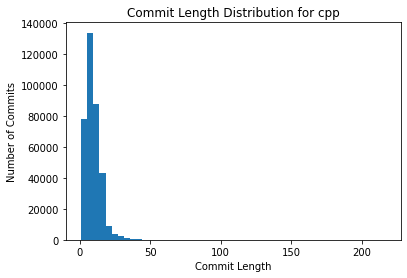

Number of commits: 360000
Average commit length: 9.422855555555556
Max commit length: 217
Min commit length: 1

Processing language: java


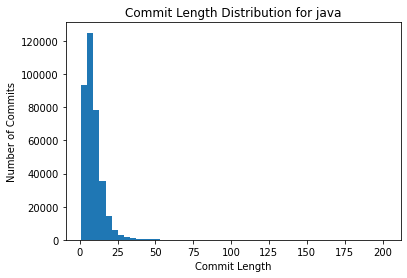

Number of commits: 360000
Average commit length: 9.323980555555556
Max commit length: 202
Min commit length: 1

Processing language: python


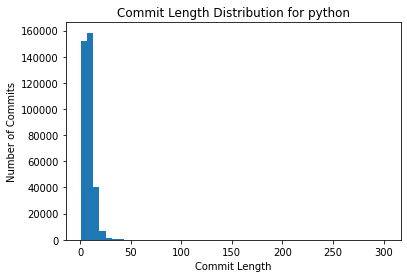

Number of commits: 360000
Average commit length: 9.01865
Max commit length: 302
Min commit length: 1

Processing language: javascript


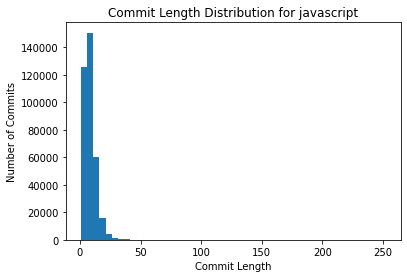

Number of commits: 360000
Average commit length: 8.843480555555555
Max commit length: 252
Min commit length: 1

Processing language: csharp


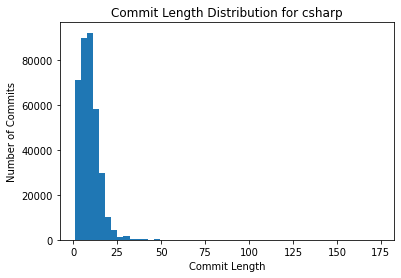

Number of commits: 360000
Average commit length: 9.287088888888889
Max commit length: 174
Min commit length: 1



In [5]:
# get the length distribution of commits for each language in the train set
def plot_histogram(data, title, xlabel, ylabel, bins=50):
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

for language in LANGUAGES:
    print('Processing language: {}'.format(language))
    dataset_path = os.path.join(BASE_DATASET_PATH, language, BASE_SPLIT_NAME)
    commit_file_path = os.path.join(dataset_path, 'train' + COMMIT_FILE_SUFFIX)
    commit_file = open(commit_file_path, 'r')
    commit_lines = commit_file.readlines()
    commit_lengths = [len(line.split()) for line in commit_lines]
    plot_histogram(commit_lengths, 'Commit Length Distribution for {}'.format(language), 'Commit Length', 'Number of Commits')
    print('Number of commits: {}'.format(len(commit_lengths)))
    print('Average commit length: {}'.format(sum(commit_lengths) / len(commit_lengths)))
    print('Max commit length: {}'.format(max(commit_lengths)))
    print('Min commit length: {}'.format(min(commit_lengths)))
    print('')

### Most frequent words 
Because we haven't preprocessed the dataset, the bar plot of the most frequent words across all the languages seem to present us a similar combination of various stop words. But interestingly, even for non-stop words, there are noticeable word overlaps. Words like **"merge", "request" and "pull"** tells us that a majority of the commit messages are actually on closing or merging various pull requests. This is and expected behaviour, because in the larger and established repositories, it is not possible to just make pushes to the `main`/`master` branch without first creating an appropriate pull request - which first gets reviewed by the repo maintainers and the upon approval gets `merged` with the main branch.

Processing language: cpp


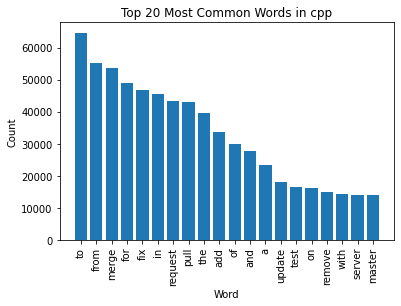


Processing language: java


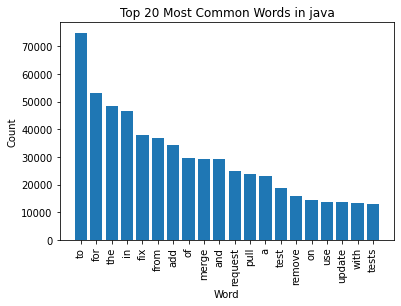


Processing language: python


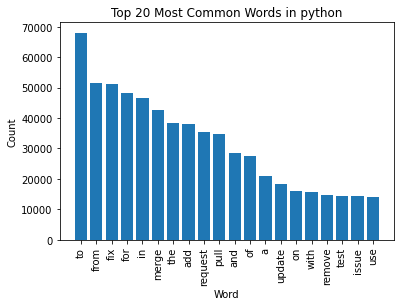


Processing language: javascript


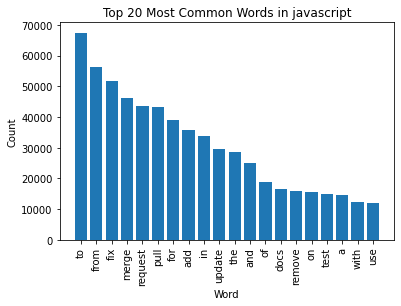


Processing language: csharp


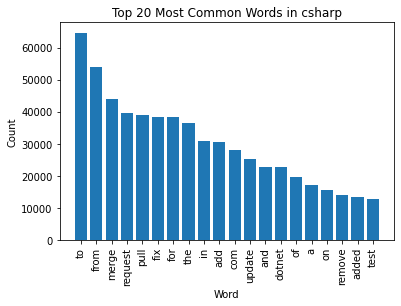

In [6]:
# generate barplot of top 20 most common words in the commit messages for each language
import string 
def plot_barplot(data, title, xlabel, ylabel, top_n=20):
    data = data.most_common(top_n)
    words = [word for word, count in data]
    counts = [count for word, count in data]
    plt.bar(words, counts)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=90)
    plt.show()


def preprocess_word(word):
    word = word.lower()
    word = word.translate(str.maketrans('', '', string.punctuation))
    word = word.translate(str.maketrans('', '', string.digits))
    return word

for language in LANGUAGES:
    print('Processing language: {}'.format(language))
    dataset_path = os.path.join(BASE_DATASET_PATH, language, BASE_SPLIT_NAME)
    commit_file_path = os.path.join(dataset_path, 'train' + COMMIT_FILE_SUFFIX)
    commit_file = open(commit_file_path, 'r')
    commit_lines = commit_file.readlines()
    commit_words = [line.split() for line in commit_lines]
    commit_words = [word for line in commit_words for word in line]
    commit_words = [preprocess_word(word) for word in commit_words]
    commit_words = [word for word in commit_words if len(word.strip()) > 0]
    commit_words = Counter(commit_words)
    plot_barplot(commit_words, 'Top 20 Most Common Words in {}'.format(language), 'Word', 'Count')
    print('')



### Most frequent verbs 
Similarly, after plotting the most frequent verbs across all the languages, we can see that the most frequent verbs are **"add", "update", "fix", "remove", "change"**. This is also an expected behaviour, because these are the most common actions that are performed in a commit.

Processing language: cpp


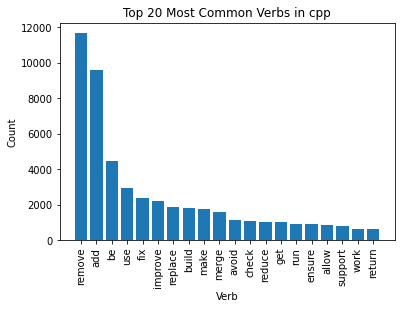

Processing language: java


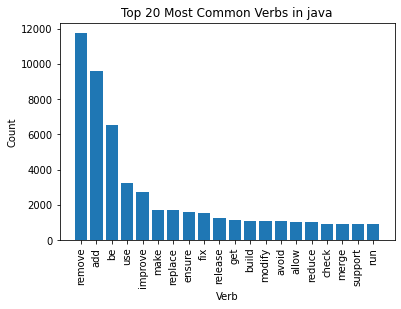

Processing language: python


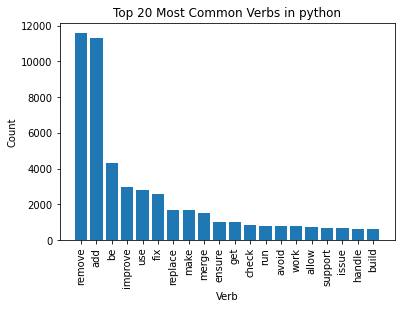

Processing language: javascript


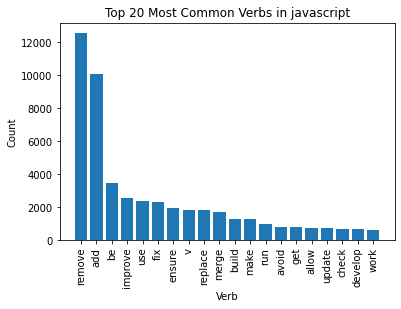

Processing language: csharp


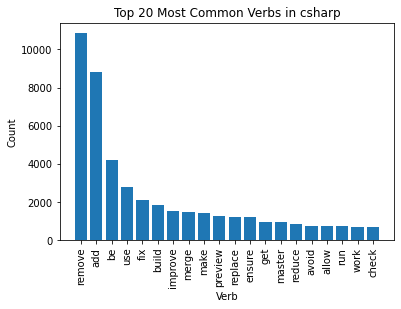

In [8]:
def identify_verbs(commit_words):
    commit_words = nltk.pos_tag(commit_words)
    commit_words = [word for word, tag in commit_words if tag == 'VB']
    return commit_words

for language in LANGUAGES :
    print('Processing language: {}'.format(language))
    dataset_path = os.path.join(BASE_DATASET_PATH, language, BASE_SPLIT_NAME)
    commit_file_path = os.path.join(dataset_path, 'train' + COMMIT_FILE_SUFFIX)
    commit_file = open(commit_file_path, 'r')
    commit_lines = commit_file.readlines()
    commit_words = [line.split() for line in commit_lines]
    commit_words = [word for line in commit_words for word in line]
    commit_words = [preprocess_word(word) for word in commit_words]
    commit_words = [word for word in commit_words if len(word.strip()) > 0]
    # identify the verbs in the commit messages
    verbs = identify_verbs(commit_words)
    verbs = Counter(verbs)
    plot_barplot(verbs, 'Top 20 Most Common Verbs in {}'.format(language), 'Verb', 'Count')

Overall, we can say that we have a large enough dataset to train a commit message generation model. However, the dataset is not very clean and there is a lot of noise in it.